# **Causal Modeling FCDO**

This is the script containing the Causal Model for the FCDO project with the reduced features It contains several parts:

1.   Install and import relevant modules and packages: All the python and R related packages will be installed in this chapter. Because some of the causal models rely heavily on modules avilable in R, substantial time is required to install and import all these packages. When same installations are followed, one is able to replcate the results in the notebook by executing the cells. 
2.   Data Preprocessing: in this chapter we deal with objects types and probematic column names, include new features based on range and manage missing data.
3.   Causal Modeling Instantation: the causal model is defined in a class function along with its parameters for the instantiation of the causal model. Choices made are accompanied by comments and docstrings together with references to papers. Two causal discovery methods are used and their results are shown.  
4.   Causal Modeling Collection of Results: this chapter merely serves to extract all the necessary and relevant data, which are the causal graphs, the causal estimates and the latent causal estimates.
5.   Saving of the data in the appropriate dotfile.

The notebook is accompanied by clarification comments and references to the papers for which algorithms have been adopted.

For running the causal model we take the dimensionality reduced data. This data has been preprocessed and the dimensionality has been reduced according to Nonlinear_Dimensionality_Reduction_FCDO.ipynb (also in this repository). This is a work in progress. The following points should be improved upon:
1.   Non-linear Dimensionality reduced features. The improvement necessary is two-fold. First, the variables should not be multiplied beyond necessity. A review of the groupings as input for the dimensionality reducing algorithm as well as a review as input for the causal model is necessary to ensure this. Second, the estimates of the dimensionality reduced features should be interpretation along the lines of the used dimensionality reduction technique. 
2.   Use of data. The current models only contains climatological related variables and conflict variables. Hypothesized is that food related variables in population related variables also explain a role in the causal mechanism. These should therefore be included.



## **Imports**

In [2]:
!pip install pandas==1.1.5 &> /dev/nul
!pip install tables==3.5.1 &> /dev/nul
!pip install cdt &> /dev/nul
!pip install rpy2 &> /dev/nul
!sudo apt install graphviz libgraphviz-dev graphviz-dev pkg-config &> /dev/nul
!pip install pygraphviz &> /dev/nul
!pip install pydot &> /dev/nul
!pip install pyparsing==1.5.7 &> /dev/nul
!pip install GML &> /dev/nul
!pip install unidecode &> /dev/nul
!pip install dowhy &> /dev/nul
!pip install statsmodels &> /dev/nul
!pip install pickle-mixin &> /dev/nul
!pip install pyyaml==5.4.1 &> /dev/nul
!pip install ananke-causal &> /dev/nul
!pip install -U javabridge &> /dev/nul
!pip install git+https://github.com/bd2kccd/py-causal &> /dev/nul

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


<!DOCTYPE doctype html>
<html lang="en"> <head> <meta charset="utf-8"/> <meta content="ie=edge" http-equiv="x-ua-compatible"/><link href="https://cdn.statically.io/img/htmlsave.com/images/html-save-flat.png?f=auto" rel="icon" type="image/x-icon"/> <meta content="width=device-width, initial-scale=1" name="viewport"/><meta content="noindex" name="robots"><link href="https://cdn.statically.io/gh/savehtml/static/d6fc97f6/errordocstyle.min.css" rel="stylesheet" type="text/css"/> <script src="https://cdn.statically.io/gh/savehtml/static/70997bac/poweredby.js" type="text/javascript"></script></meta></head> <body> <main> <figure> <a href="https://htmlsave.com" rel="dofollow"></a> </figure><title>Error Found</title><section><header><h1>Error Found <a style="color:MediumSeaGreen;">404</a></h1></header><p>The page you were looking for doesn't exist on this server.</p><ul><li><a href="javascript:location.reload();">Try reloading the page</a></li><li><a href="javascript:history.back();">Go back to 
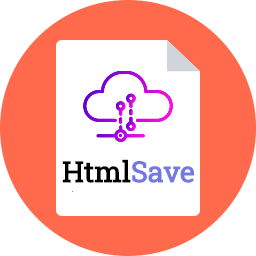

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tables
import numpy as np
import scipy
import logging.config
import sys
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
import GPUtil
import unidecode
import joblib
import torch
import tqdm
import requests
import difflib as dl
import sklearn
import cdt #CDT depends on a number of other packages, including these R packages: https://github.com/FenTechSolutions/CausalDiscoveryToolbox/blob/master/r_requirements.txt. 
#Please see below.
from cdt.causality.graph import GES
import networkx as nx
import GML
import pickle
import dowhy
from dowhy import CausalModel
import statsmodels
import statsmodels.api 
from IPython.display import Image, display
from google.colab import auth
from itertools import permutations
import ananke
from ananke.graphs import ADMG
from ananke.estimation import CausalEffect
import pygraphviz
import pydot
import pydotplus
import pyparsing
import javabridge
import torch
import tqdm
import pycausal
from pycausal import search as s
from pycausal.pycausal import pycausal as pc
from IPython.display import SVG

In [4]:
base = importr('base')
utils = importr('utils')

utils.chooseCRANmirror(ind=1)
packnames_CRAN_direct = ('devtools', 'BiocManager', 'sparsebn', 'pcalg', 'gRain', 'bnlearn') #Alternatively, 'http://www.bnlearn.com/releases/bnlearn_latest.tar.gz'
names_to_install_CRAN_direct = [x for x in packnames_CRAN_direct if not rpackages.isinstalled(x)]
if len(names_to_install_CRAN_direct) > 0:
    utils.install_packages(StrVector(names_to_install_CRAN_direct))

biocmanager = importr('BiocManager')
packnames_biocmanager = ('graph', 'RBGL', 'Rgraphviz', 'gRain')
names_to_install_biocmanager = [x for x in packnames_biocmanager if not rpackages.isinstalled(x)]
if len(names_to_install_biocmanager) > 0:
    biocmanager.install(StrVector(names_to_install_biocmanager))

devtools = importr('devtools')
packnames_github = ('cran/CAM', 'cran/D2C', 'cran/SID', 'Diviyan-Kalainathan/RCIT')
names_to_install_github = [x for x in packnames_github if not rpackages.isinstalled(x)]
if len(names_to_install_github) > 0:
    devtools.install_github(StrVector(names_to_install_github), force = True)

pcalg = importr('pcalg')
graph = importr('graph')
rbgl = importr('RBGL')
rgraphviz = importr('Rgraphviz')
bnlearn = importr('bnlearn')
cam = importr('CAM')
d2c = importr('D2C')
sid = importr('SID')
rcit = importr('RCIT')

(as ‘lib’ is unspecified)














































































































	‘/tmp/RtmpXA8qVi/downloaded_packages’

'?repositories' for details

replacement repositories:
    CRAN: https://cloud.r-project.org










































	‘/tmp/RtmpXA8qVi/downloaded_packages’

  'tinytex', 'tzdb', 'cluster', 'MASS', 'Matrix', 'mgcv', 'nlme'



Update all/some/none? [a/s/n]: a











































	‘/tmp/RtmpXA8qVi/downloaded_packages’



























	‘/tmp/RtmpXA8qVi/downloaded_packages’




(as ‘lib’ is unspecified)



































































	‘/tmp/RtmpXA8qVi/downloaded_packages’



* checking for file ‘/tmp/RtmpXA8qVi/remotes3c768f4037/cran-CAM-fbc593d/DESCRIPTION’ ... OK
* preparing ‘CAM’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘CAM_1.0.tar.gz’



(as ‘lib’ is unspecified)




(as ‘lib’ is unspecified)












	‘/tmp/RtmpXA8qVi/downloaded_packages’



* checking for file ‘/tmp/RtmpXA8qVi/remotes3c4aeba063/cran-D2C-482b186/DESCRIPTION’ ... OK
* preparing ‘D2C’:
* checking DESCRIPTION meta-information ... OK
* checking vignette meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘D2C_1.2.1.tar.gz’



(as ‘lib’ is unspecified)




(as ‘lib’ is unspecified)












	‘/tmp/RtmpXA8qVi/downloaded_packages’



* checking for file ‘/tmp/RtmpXA8qVi/remotes3c5755526/cran-SID-9e4ab7e/DESCRIPTION’ ... OK
* preparing ‘SID’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘SID_1.0.tar.gz’



(as ‘lib’ is unspecified)



(as ‘lib’ is unspecified)







	‘/tmp/RtmpXA8qVi/downloaded_packages’



* checking for file ‘/tmp/RtmpXA8qVi/remotes3c4e033076/Diviyan-Kalainathan-RCIT-c97f91c/DESCRIPTION’ ... OK
* preparing ‘RCIT’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘RCIT_0.1.0.tar.gz’



(as ‘lib’ is unspecified)



In [5]:
cdt.SETTINGS.GPU
cdt.SETTINGS.NJOBS
cdt.SETTINGS.NJOBS = 3
cdt.SETTINGS.verbose = False

In [6]:
url = 'https://raw.githubusercontent.com/HCSS-Data-Lab/FCDO/main/Data/FCDO_data_dim_reduced.csv'
data_reduced = pd.read_csv(url) # Import prepared data
del data_reduced['Unnamed: 0']

In [7]:
data_reduced

,Water_Runoff,Coastal,Landslide,Storm_Surface,Riverine,Precipitation,Evapotranspiration,Skin_Reservoir,Evaporation,Soil_Temperature,...,Strategic developments,Violence against civilians,total_event_types,"fatalities, Battles","fatalities, Explosions/Remote violence","fatalities, Protests","fatalities, Riots","fatalities, Strategic developments","fatalities, Violence against civilians","total_fatalities,"
0,-9.785743,13.071511,-29.065561,-4.913549,6.574868,3.072558,-5.588446,-2.096827,3.877077,-5.948453,...,0,2,6,0,0,0,0,0,2,2
1,-4.451058,4.962664,-23.626535,9.772707,0.807747,8.971795,-1.891566,-8.279265,5.505229,-0.574631,...,1,2,13,3,5,0,0,0,1,9
2,-11.909466,11.712390,-29.582335,0.864251,6.113179,4.052352,-4.988898,-0.585704,3.359438,-5.382941,...,7,7,61,31,30,0,0,0,9,70
3,7.758137,15.811904,-16.693804,7.044371,10.137346,-7.126973,3.069797,4.485955,-6.747284,6.822594,...,1,0,4,0,2,0,0,0,0,2
4,-6.743314,-8.275314,-28.289974,-6.074180,-9.680875,6.680084,-7.311238,-8.077782,4.487056,-10.362889,...,2,5,32,4,0,0,1,0,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,-3.214485,2.588127,105.697720,3.687900,-3.637111,0.374221,-1.623459,-8.998659,-9.054413,-7.769559,...,0,0,1,0,0,0,0,0,0,0
264,-2.088866,-7.943555,-24.605865,3.153948,-10.300833,-2.507312,0.813194,-7.614503,-5.791650,0.804240,...,14,2,52,97,61,0,0,3,1,162
265,-6.108713,5.823532,106.002380,-9.769992,1.107011,2.518385,-5.584548,0.394428,2.808425,-2.500868,...,4,5,73,35,4,0,0,0,5,44
266,8.186574,-4.825429,-19.113450,11.183458,1.367947,-9.118014,4.459762,8.672816,-6.498763,9.030070,...,0,0,5,0,9,0,0,0,0,9


## **Causal Modelling**

In [132]:
class StaticCausalModel:
  """
  Class function that contains relevant causal model objects as attributes.  
  Attributes:
      networkx_graph (networkx.Digraph): Extract causal DAG with GLASSO - GES combination
      create_PAG (tetrad object): Extract causal PAG without causal sufficiency or faithfulness assumption
      PAG2ADMG (ananke ADMG object): convert the extracted PAG two ADMG
      extract_causal_graph (DoWhy Causal Model object): convert DAG to DoWhy causal model
      return_directed_paths (list): list all the combinations of nodes for which there exist a causal path
      return_paths (pd.Dataframe): list all the combinations of nodes for which there exist a causal path
      view_ADMG (): draw the ADMG
      view_graph (): draw the DAG
      identification (identified object DoWhy): identify causal effect in the DAG
      latent_identification (identified object Ananke): identify causal effect in the ADMG
      estimation (float, float str): estimate causal effects in the DAG and return the causal effect, standard error and p-value
      latent_estimation (float, float float): estimate causal effects in the ADMG and returns causal effect, lower quantile and upper quantile.
  """
  # Note this class function mixes cdt functions to extract the causal graph with dowhy functions to identify, estimate and refute the causal effect.
  def __init__(self, data_to_graph, feature_selection, method_parameters, treatment, outcome):
    """
    Initiate arguments and logger
    :param features (list) : list of the used columns
    :param data (pd.Dataframe) : data
    :param method_params (dict) : dictionairy with method parameters
    :param treatment (str) : considered treatment in causal model
    :param outcome (str) : considered outcome in causal model
    """
    self.features = feature_selection
    self.data = data_to_graph[self.features]
    self.method_params = method_parameters
    self.Glasso = cdt.independence.graph.Glasso() 
    self.ges = cdt.causality.graph.GES() 
    self.treatment = treatment
    self.outcome = outcome

  def networkx_graph(self):
    """
    Uses GLASSO to obtain the skeleton which is used as argument obtaining the causal graph with GES when causal sufficiency is assumed.
      Ref : Friedman, J., Hastie, T., & Tibshirani, R. (2008). Sparse inverse covariance estimation with the graphical lasso. Biostatistics, 9(3), 432-441.
      Ref: D.M. Chickering (2002). Optimal structure identification with greedy search. Journal of Machine Learning Research 3 , 507–554
    :return (networkx.Digraph): Extracted causal DAG with causal sufficiency
    """
    skeleton = self.Glasso.predict(self.data, alpha=1)
    return self.ges.predict(self.data, skeleton) 

  def create_PAG(self):
    """
    GFCI works well on small sample sizes,
      Ref : Ogarrio, J. M., Spirtes, P., & Ramsey, J. (2016, August). A hybrid causal search algorithm for latent variable models. In Conference on probabilistic graphical models (pp. 368-379). PMLR.
    :return (tetrad object): Extracted causal PAG without causal sufficicency assumption
    """
    pc.start_vm(java_max_heap_size = '6g') #Starting a Java virtual machine
    tetrad = s.tetradrunner()
    tetrad.getAlgorithmParameters(algoId = 'gfci', testId = 'cg-lr-test', scoreId = 'cg-bic-score') 
    tetrad.run(algoId = 'gfci', dfs = self.data, testId = 'cg-lr-test', scoreId = 'cg-bic-score', dataType = 'continuous', 
           numCategoriesToDiscretize = 30, maxDegree = 20, maxPathLength = 20,
           completeRuleSetUsed = True, faithfulnessAssumed = False) #faithfullness not assumed
    return tetrad

  def PAG2ADMG(self):
    """
    Convert PAG to ADMG sending --> and o-> to --> and o-o and <-> to <->. Multiple conversions are used for verification process. For a complete enumeration for possible ADMG's given PAG's, see
      Ref : Subramani, N. (2016). Pag2admg: An algorithm for the complete causal enumeration of a markov equivalence class. arXiv preprint arXiv:1612.00099.
    :return (ananke ADMG object): Extracted ADMG form PAG using bruteforce method
    """
    tetrad = StaticCausalModel.create_PAG(self)
    vertices = tetrad.getNodes()
    edges= tetrad.getEdges()
    # Send --> and o-> to --> and o-o and <-> to <->. 
    bidirection = ['<->','o-o']
    direction =['-->', 'o->']
    # Check the edges for direction
    bi_edges = [(edge.rsplit(' ',-1)[0],edge.rsplit(' ',-1)[2])  for edge in edges if any(x in edge.rsplit(' ',-1)[1] for x in bidirection)] 
    di_edges = [(edge.rsplit(' ',-1)[0],edge.rsplit(' ',-1)[2])  for edge in edges if any(x in edge.rsplit(' ',-1)[1] for x in direction)]
    return ADMG(vertices, di_edges, bi_edges)

  def extract_causal_graph(self):
    """
    Convert DAG to DoWhy causal graph object. Remove problematic arrows (verify removal by latent estimates).
    :return (dowhy Causal Model object): Extracted ADMG form PAG using bruteforce method
    """
    output_graph = StaticCausalModel.networkx_graph(self)
    nx.write_gml(output_graph, "G.gml")
    # CausalModel is a dowhy function to initiate the model based on the extracted causal graph. 
    return CausalModel(data = self.data, treatment=self.treatment, outcome=self.outcome, graph= 'G.gml') # Note this is the model input required by dowhy

  def return_directed_paths(self):
    """
    Return the combinations of nodes for which there exist a directed path in the causal graph.
    :return (list): List of combinations of nodes.
    """
    DAG = StaticCausalModel.networkx_graph(self)
    combinations = list(permutations(DAG.nodes(), 2))
    return [combination  for combination in combinations if nx.has_path(DAG ,combination[0], combination[1])]

  def return_paths(self, start, end):
    """
    Return the directed paths based on start and end node.
    :start (str): startnode
    :node (str): endnode
    :return (list): List of causal paths
    """
    DAG = StaticCausalModel.networkx_graph(self)
    return [path for path in nx.all_simple_paths(DAG ,start, end)]

  def view_ADMG(self):
    """
    View ADMG
    :return (ADMG): Drawn ADMG
    """
    return StaticCausalModel.PAG2ADMG(self).draw(direction="LR")

  def view_graph(self):
    """
    View DAG
    :return (DAG): Drawn DAG   
    """
    return StaticCausalModel.extract_causal_graph(self).view_model(layout="dot")

  def identification(self):
    """
    Identify Causal Effect (if exists) in the DAG
    :return (identified object): a probability expression (estimand) for the causal effect if identified, else NULL
    """
    return StaticCausalModel.extract_causal_graph(self).identify_effect()

  def latent_identification(self):
    """
    Identify Causal Effect (if exists) in the ADMG
    :return (identified object): a recommendation of latent estimators if identifiable   
    """
    return CausalEffect(graph = StaticCausalModel.PAG2ADMG(self), treatment = self.treatment, outcome = self.outcome)

  def estimation(self):
    """
    The estimated causal effect based on generalized linear model and given method parameters.
    :return (float): causal effect
    :return (float): standard error
    :return (str): p-value
    """
    #Dowhy function estimate_effect to estimate effect. Note we use generalized linear model with method_params defined with the causal models params.
    glm_estimate = StaticCausalModel.extract_causal_graph(self).estimate_effect(identified_estimand = StaticCausalModel.identification(self), method_name="backdoor.generalized_linear_model", 
                                                                                test_significance=True, confidence_intervals = True, method_params = self.method_params)
    return glm_estimate, glm_estimate.get_standard_error(method = "bootstrap"), glm_estimate.test_stat_significance(method = "bootstrap").get('p_value')

  def latent_estimation(self, latent_significance):
    """
    The estimated causal effect based on gformula and bootstrap methods with significance levels. For causal estimation in ADMG's and the significance with bootstrap method respectively see:
      Ref : Bhattacharya, R., Nabi, R., & Shpitser, I. (2020). Semiparametric inference for causal effects in graphical models with hidden variables. arXiv preprint arXiv:2003.12659.
      Ref : Ridgeway, G. (2007). All of Nonparametric Statistics, Larry Wasserman. Journal of the American Statistical Association, 102, 389-389.
    :return (float): causal effect
    :return (float): lower quantile
    :return (float): upper quantile
    """
    #Ananke function compute_effect to estimate effect. Decide the signficance level.
    ace, q1, qu = StaticCausalModel.latent_identification(self).compute_effect(self.data, "gformula", n_bootstraps = 50, alpha=latent_significance)
    return ace, q1, qu 

In [9]:
pc = pc() #Initialization of javabridge

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Latent_Heat'] on outcome ['total_event_types']


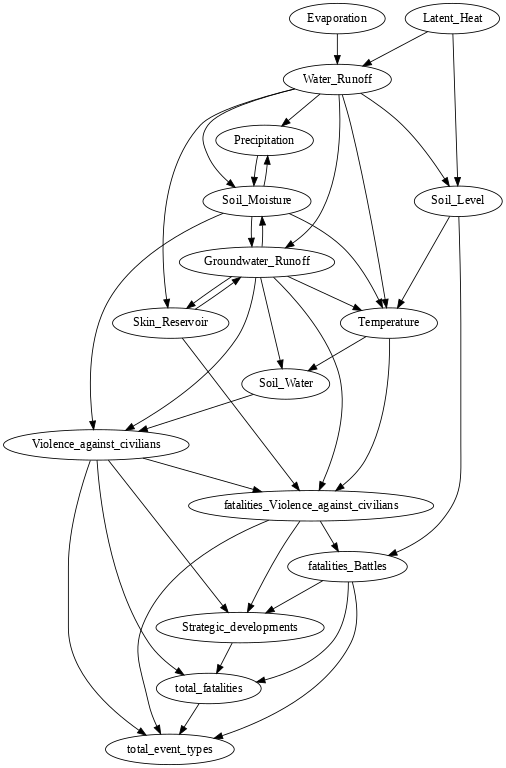

In [144]:
# Specify the features to be used. For an exact mapping of raw data to reduced data look at Nonlinear_Dimensionality_Reduction_FCDO.ipynb

features = ['Water_Runoff', 'Soil_Level', 'Soil_Water', 'Precipitation', 'Soil_Level', 'Groundwater_Runoff', 'Temperature', 'Latent_Heat',
                               'Soil_Moisture', 'Evaporation', 'Skin_Reservoir', 'fatalities_Battles','Strategic_developments',
                              'Violence_against_civilians','total_event_types','fatalities_Violence_against_civilians', 'total_fatalities']

feature_selection = features

#Static causal model takes treatment and outcome as arguments:
treatment = 'Latent_Heat' 
outcome = 'total_event_types'

causal_data = data_reduced

# Rename some of the features such that the results will be readable.
causal_data.rename(columns={'total_fatalities, ':'total_fatalities', 'fatalities, Battles':'fatalities_Battles', 'Violence against civilians':'Violence_against_civilians',
                            'fatalities, Violence against civilians':'fatalities_Violence_against_civilians', 'Strategic developments':'Strategic_developments'}, inplace=True)

#Select the method parameters
method_parameters = {'num_null_simulations':50, 'method': 'bootstrap', 'num_simulations':50, 
                 'need_conditional_estimates': False, 'fit_method': "statsmodels", 'glm_family':statsmodels.api.families.NegativeBinomial(alpha=0.001)} #Conflicts are sticky. Thus, we use the Negative Binomial distributions. Alternatively, one can use Poisson()

# Initiate Causal Model an view causal graph
causal_model = StaticCausalModel(causal_data, feature_selection, method_parameters, treatment, outcome)
causal_model.view_graph()
display(Image(filename="causal_model.png"))

faithfulnessAssumed: This is a parameter for FGES (“Fast GES”). If this is set to ‘Yes’, it will be assumed that if X _||_ Y, by an independence test, then X _||_ Y | Z for nonempty Z. If the model is faithful to the data, this will necessarily be the case. However, there are some non-faithful examples one can propose where this is not the case. If one is worried about this kind of unfaithfulness, one should set this parameter to ‘No’. If one is willing to tolerate this kind of unfaithfulness, then setting this parameter to ‘Yes’ leads to significantly faster searches. (java.lang.Boolean) [default:true]
maxDegree: It is possible for a random graph to have a single node with very high degree—i.e. number of adjacent edges. This parameter places an upper bound on the maximum such degree. If no limit is to be placed on the maximum degree, use the value -1. (java.lang.Integer) [default:100]
maxPathLength: See Spirtes, Glymour, and Scheines (2000), Causation, Prediction, and Search for the d

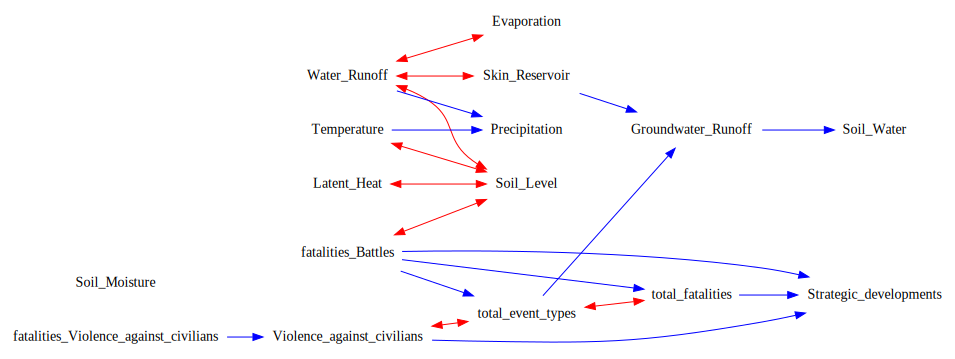

In [136]:
# Specify the features to be used. For an exact mapping of raw data to reduced data look at Nonlinear_Dimensionality_Reduction_FCDO.ipynb

features = ['Water_Runoff', 'Soil_Level', 'Soil_Water', 'Precipitation', 'Groundwater_Runoff', 'Temperature', 'Latent_Heat',
                               'Soil_Moisture', 'Evaporation', 'Skin_Reservoir', 'fatalities_Battles','Strategic_developments',
                              'Violence_against_civilians','total_event_types','fatalities_Violence_against_civilians', 'total_fatalities']

feature_selection = features

#Static causal model takes treatment and outcome as arguments:
treatment = 'Soil_Moisture' 
outcome = 'total_fatalities'

causal_data = data_reduced

# Rename some of the features such that the results will be readable.
causal_data.rename(columns={'total_fatalities, ':'total_fatalities', 'fatalities, Battles':'fatalities_Battles', 'Violence against civilians':'Violence_against_civilians',
                            'fatalities, Violence against civilians':'fatalities_Violence_against_civilians', 'Strategic developments':'Strategic_developments'}, inplace=True)

#Select the method parameters
method_parameters = {'num_null_simulations':50, 'method': 'bootstrap', 'num_simulations':50, 
                 'need_conditional_estimates': False, 'fit_method': "statsmodels", 'glm_family':statsmodels.api.families.NegativeBinomial(alpha=0.001)} #Conflicts are sticky. Thus, we use the Negative Binomial distributions. Alternatively, one can use Poisson()

# Initiate Causal Model an view causal graph
causal_model = StaticCausalModel(causal_data, feature_selection, method_parameters, treatment, outcome)
causal_model.view_ADMG()

## **Calculate all Results**

In [139]:
# List the variables for which the causal effect should be calculated.
relevant_treatments = ['Water_Runoff', 'Soil_Level', 'Soil_Water', 'Precipitation', 'Groundwater_Runoff', 'Temperature', 'Latent_Heat',
                               'Soil_Moisture', 'Evaporation', 'Skin_Reservoir', 'fatalities_Battles','Strategic_developments',
                              'Violence_against_civilians','total_event_types','fatalities_Violence_against_civilians']

In [29]:
#Create the output DataFrame
causal_output = pd.DataFrame(data=causal_model.return_directed_paths(), columns=['Treatment','Outcome']) #Return all the possible combinations for which directed paths exist
causal_output = causal_output[causal_output['Outcome'].isin([outcome])] #Filter for outcome on reported fatalities
causal_output = causal_output[causal_output['Treatment'].isin(relevant_treatments)].reset_index(drop=True) #Filter for treatment on relevant treatments
causal_output['Paths'] = [causal_model.return_paths(causal_output.loc[i,'Treatment'], causal_output.loc[i,'Outcome']) for i in range(0,len(causal_output))] # return the actual paths
causal_output

,Treatment,Outcome,Paths
0,Water_Runoff,total_fatalities,"[[Water_Runoff, Soil_Level, Temperature, Soil_..."
1,Soil_Level,total_fatalities,"[[Soil_Level, Temperature, Soil_Water, total_e..."
2,Soil_Water,total_fatalities,"[[Soil_Water, total_event_types, total_fatalit..."
3,Precipitation,total_fatalities,"[[Precipitation, Temperature, Soil_Water, tota..."
4,Groundwater_Runoff,total_fatalities,"[[Groundwater_Runoff, Soil_Water, total_event_..."
5,Temperature,total_fatalities,"[[Temperature, Soil_Water, total_event_types, ..."
6,Latent_Heat,total_fatalities,"[[Latent_Heat, Water_Runoff, Soil_Level, Tempe..."
7,Soil_Moisture,total_fatalities,"[[Soil_Moisture, Groundwater_Runoff, Soil_Wate..."
8,Evaporation,total_fatalities,"[[Evaporation, Water_Runoff, Soil_Level, Tempe..."
9,fatalities_Battles,total_fatalities,"[[fatalities_Battles, Strategic_developments, ..."


In [ ]:
#Check If Causal effects exist:
causal_effects_DAG = [] #inititiate Dataframe
causal_effects_ADMGlow = [] #inititiate Dataframe
for treatment in relevant_treatments:
  print(treatment)
  causal_model = StaticCausalModel(causal_data, feature_selection, method_parameters, treatment, outcome) #Initiate causal model for every treatment - outcome combination #TODO clean program this
  try: # try identifying estimates based on DAG identification estimands. If identification is not possible, continue. 
    identified_effect = causal_model.identification() 
    try: # try calculating estimates following DAG estimates, low significant ADMG estimates, medium significant ADMG estimates and high significant ADMG estimates. Continue if not possible.
      estimated_effect, standard_error, p_value = causal_model.estimation() #start calculating DAG estimates
      causal_effects_DAG.append([treatment, estimated_effect.value , standard_error,p_value])

      causal_model.latent_identification()
      ace, ql, qu = causal_model.latent_estimation(latent_significance=0.05) #calculate ADMG estimates based on low (*) significance
      standard_error = (qu-ql)/3.92
      causal_effects_ADMGlow.append([treatment, ace , ql, qu, standard_error])
    except:
      continue
  except:
    continue 

In [62]:
ADMG_effect_dataframe = pd.DataFrame(causal_effects_ADMGlow, columns=['Treatment','Causal_Effect','Lower_Confidence', 'Upper_Confidence','Standard_Error'])
DAG_effect_dataframe = pd.DataFrame(causal_effects_DAG, columns=['Treatment','Causal_Effect','Standard_Error', 'pvalue'])

In [63]:
ADMG_effect_dataframe

,Treatment,Causal_Effect,Lower_Confidence,Upper_Confidence,Standard_Error
0,Water_Runoff,-0.437280,-1.100419,0.062483,0.296659
1,Soil_Level,-0.122007,-0.608471,0.514123,0.286376
2,Soil_Water,1.856162,-0.451754,5.119676,1.421283
3,Precipitation,0.314430,-2.448539,2.855125,1.352975
4,Groundwater_Runoff,-0.326439,-0.978902,0.437671,0.361371
5,Temperature,0.213848,-0.133293,0.948049,0.275853
6,Latent_Heat,0.243540,-0.340311,0.769285,0.283060
7,Soil_Moisture,0.508780,-1.231476,1.821653,0.778859
8,Evaporation,0.431200,0.009664,0.814488,0.205312
9,fatalities_Battles,1.482461,1.379185,1.770038,0.099707


## **Saving Files in Dot**

In [140]:
causal_output_DAG = causal_output.merge(DAG_effect_dataframe, on='Treatment', how='left')
causal_output_ADMG = causal_output.merge(ADMG_effect_dataframe, on='Treatment', how='left')

In [141]:
causal_output_DAG

,Treatment,Outcome,Paths,Causal_Effect,Standard_Error,pvalue
0,Water_Runoff,total_fatalities,"[[Water_Runoff, Soil_Level, Temperature, Soil_...",0.436270,0.944483,0.12
1,Soil_Level,total_fatalities,"[[Soil_Level, Temperature, Soil_Water, total_e...",2.064128,0.749216,"(0, 0.02)"
2,Soil_Water,total_fatalities,"[[Soil_Water, total_event_types, total_fatalit...",1.651091,0.912599,0.04
3,Precipitation,total_fatalities,"[[Precipitation, Temperature, Soil_Water, tota...",-0.266228,1.056191,0.42
4,Groundwater_Runoff,total_fatalities,"[[Groundwater_Runoff, Soil_Water, total_event_...",0.438245,1.766622,0.12
5,Temperature,total_fatalities,"[[Temperature, Soil_Water, total_event_types, ...",1.110033,0.715558,0.16
6,Latent_Heat,total_fatalities,"[[Latent_Heat, Water_Runoff, Soil_Level, Tempe...",3.700684,1.702207,"(0, 0.02)"
7,Soil_Moisture,total_fatalities,"[[Soil_Moisture, Groundwater_Runoff, Soil_Wate...",-0.749825,0.711932,0.2
8,Evaporation,total_fatalities,"[[Evaporation, Water_Runoff, Soil_Level, Tempe...",0.487302,0.527739,0.24
9,fatalities_Battles,total_fatalities,"[[fatalities_Battles, Strategic_developments, ...",0.296389,0.066458,0.02


In [142]:
# Renaming and including the causal effect and standard deviation
causal_output_DAG = causal_output_DAG.assign(Node_names = causal_output_DAG.Treatment.astype(str) + ': ' + \
  causal_output_DAG.Causal_Effect.astype(float).round(3).astype(str) + ', (' + (causal_output_DAG.Standard_Error.round(3).astype(str))+ ')'+ ', ['+ (causal_output_DAG.pvalue.astype(str)) +']')
# Renaming and including the causal effect and standard deviation
causal_output_ADMG = causal_output_ADMG.assign(Node_names = causal_output_ADMG.Treatment.astype(str) + ': ' + \
  causal_output_ADMG.Causal_Effect.round(3).astype(str) + ', (' + (causal_output_ADMG.Standard_Error.round(3).astype(str))+ ')' )

### **Create DAG dot file**

In [152]:
#Node Names:
output_graph = causal_model.networkx_graph()
attributes_DAG = pd.DataFrame(data = nx.spring_layout(output_graph).keys(), columns=['Treatment']) 
attributes_DAG = pd.merge(attributes_DAG, causal_output_DAG[['Treatment','Node_names']], how='left', on='Treatment') 
attributes_DAG.loc[attributes_DAG['Treatment']=='total_fatalities','Node_names']='Outcome: # total_fatalities'
attributes_DAG.Node_names.fillna(attributes_DAG.Treatment, inplace=True)
attributes_DAG.loc[attributes_DAG['Node_names'].str.contains('nan'), 'Node_names'] = attributes_DAG.loc[attributes_DAG['Node_names'].str.contains('nan'), 'Treatment']
attributes_DAG

# Color Labels 
colors = causal_output_DAG[['Treatment','Causal_Effect']]

# Try to map values to colors in hex
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.RdYlGn_r)
colors['Color_Hex'] = colors['Causal_Effect'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
attributes_DAG = pd.merge(attributes_DAG, colors[['Treatment','Color_Hex']], how='left', on='Treatment') 
attributes_DAG.loc[attributes_DAG['Color_Hex']=='#000000','Color_Hex']='#ffffff'
attributes_DAG.loc[attributes_DAG['Treatment']=='total_fatalities','Color_Hex']='#0095ff' # Blue for the outcome
attributes_DAG.fillna('#ffffff', inplace=True) # rest of colors is just white
attributes_DAG['fontcolor']='white'

#Edge labels
edge_attributes=pd.DataFrame(data = output_graph.edges, columns=['From','To']) 
edge_attributes['color'] = 'black'
edge_attributes['fontcolor'] = 'black'

edgecolormapping = dict(zip(list(zip(edge_attributes.From,edge_attributes.To)), edge_attributes.color))
edgefontcolormapping = dict(zip(list(zip(edge_attributes.From,edge_attributes.To)), edge_attributes.color))

colormapping = dict(zip(attributes_DAG.Treatment, attributes_DAG.Color_Hex))
labelmapping = dict(zip(attributes_DAG.Treatment, attributes_DAG.Node_names))
fontcolormapping = dict(zip(attributes_DAG.Treatment, attributes_DAG.fontcolor))

output_graph = causal_model.networkx_graph()
nx.get_node_attributes(output_graph,'label')
#nx.set_node_attributes(output_graph, colormapping, name="fillcolor")
nx.set_node_attributes(output_graph, labelmapping, name="label")
nx.set_node_attributes(output_graph, fontcolormapping, name="color")

nx.set_edge_attributes(output_graph, edgecolormapping, name="color")
nx.set_edge_attributes(output_graph, edgecolormapping, name="fontcolor")

In [153]:
dotfile = nx.drawing.nx_pydot.write_dot(output_graph, "FCDO_DAG_tot_fatalities.dot")
from google.colab import files
files.download('FCDO_DAG_tot_fatalities.dot')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Create ADMG dot file**

In [147]:
causal_output_ADMG

,Treatment,Outcome,Paths,Causal_Effect,Lower_Confidence,Upper_Confidence,Standard_Error,Node_names
0,Water_Runoff,total_fatalities,"[[Water_Runoff, Soil_Level, Temperature, Soil_...",-0.437280,-1.100419,0.062483,0.296659,"Water_Runoff: -0.437, (0.297)"
1,Soil_Level,total_fatalities,"[[Soil_Level, Temperature, Soil_Water, total_e...",-0.122007,-0.608471,0.514123,0.286376,"Soil_Level: -0.122, (0.286)"
2,Soil_Water,total_fatalities,"[[Soil_Water, total_event_types, total_fatalit...",1.856162,-0.451754,5.119676,1.421283,"Soil_Water: 1.856, (1.421)"
3,Precipitation,total_fatalities,"[[Precipitation, Temperature, Soil_Water, tota...",0.314430,-2.448539,2.855125,1.352975,"Precipitation: 0.314, (1.353)"
4,Groundwater_Runoff,total_fatalities,"[[Groundwater_Runoff, Soil_Water, total_event_...",-0.326439,-0.978902,0.437671,0.361371,"Groundwater_Runoff: -0.326, (0.361)"
5,Temperature,total_fatalities,"[[Temperature, Soil_Water, total_event_types, ...",0.213848,-0.133293,0.948049,0.275853,"Temperature: 0.214, (0.276)"
6,Latent_Heat,total_fatalities,"[[Latent_Heat, Water_Runoff, Soil_Level, Tempe...",0.243540,-0.340311,0.769285,0.283060,"Latent_Heat: 0.244, (0.283)"
7,Soil_Moisture,total_fatalities,"[[Soil_Moisture, Groundwater_Runoff, Soil_Wate...",0.508780,-1.231476,1.821653,0.778859,"Soil_Moisture: 0.509, (0.779)"
8,Evaporation,total_fatalities,"[[Evaporation, Water_Runoff, Soil_Level, Tempe...",0.431200,0.009664,0.814488,0.205312,"Evaporation: 0.431, (0.205)"
9,fatalities_Battles,total_fatalities,"[[fatalities_Battles, Strategic_developments, ...",1.482461,1.379185,1.770038,0.099707,"fatalities_Battles: 1.482, (0.1)"


In [151]:
#Node Names:
output_graph = causal_model.networkx_graph()
attributes_ADMG = pd.DataFrame(data = nx.spring_layout(output_graph).keys(), columns=['Treatment']) 
attributes_ADMG = pd.merge(attributes_ADMG, causal_output_ADMG[['Treatment','Node_names']], how='left', on='Treatment') 
attributes_ADMG.loc[attributes_ADMG['Treatment']=='total_fatalities','Node_names']='Outcome: # total_fatalities'
attributes_ADMG.Node_names.fillna(attributes_ADMG.Treatment, inplace=True)
attributes_ADMG.loc[attributes_ADMG['Node_names'].str.contains('nan'), 'Node_names'] = attributes_ADMG.loc[attributes_ADMG['Node_names'].str.contains('nan'), 'Treatment']
attributes_ADMG

# Color Labels
colors = causal_output_ADMG[['Treatment','Causal_Effect']]

# Try to map values to colors in hex
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.RdYlGn_r)
colors['Color_Hex'] = colors['Causal_Effect'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
attributes_ADMG = pd.merge(attributes_ADMG, colors[['Treatment','Color_Hex']], how='left', on='Treatment') 
attributes_ADMG.loc[attributes_ADMG['Color_Hex']=='#000000','Color_Hex']='#ffffff'
attributes_ADMG.loc[attributes_ADMG['Treatment']=='total_fatalities','Color_Hex']='#0095ff' # Blue for the outcome
attributes_ADMG.fillna('#ffffff', inplace=True) # rest of colors is just white
attributes_ADMG['fontcolor']='white'

#Edge labels
edge_attributes=pd.DataFrame(data = output_graph.edges, columns=['From','To']) 
edge_attributes['color'] = 'black'
edge_attributes['fontcolor'] = 'black'

edgecolormapping = dict(zip(list(zip(edge_attributes.From,edge_attributes.To)), edge_attributes.color))
edgefontcolormapping = dict(zip(list(zip(edge_attributes.From,edge_attributes.To)), edge_attributes.color))

colormapping = dict(zip(attributes_ADMG.Treatment, attributes_ADMG.Color_Hex))
labelmapping = dict(zip(attributes_ADMG.Treatment, attributes_ADMG.Node_names))
fontcolormapping = dict(zip(attributes_ADMG.Treatment, attributes_ADMG.fontcolor))

#output_graph = causal_model.networkx_graph()
nx.get_node_attributes(output_graph,'label')
#nx.set_node_attributes(output_graph, colormapping, name="fillcolor")
nx.set_node_attributes(output_graph, labelmapping, name="label")
nx.set_node_attributes(output_graph, fontcolormapping, name="color")

nx.set_edge_attributes(output_graph, edgecolormapping, name="color")
nx.set_edge_attributes(output_graph, edgecolormapping, name="fontcolor")

In [149]:
dotfile = nx.drawing.nx_pydot.write_dot(output_graph, "FCDO_ADMG_event_type.dot")
from google.colab import files
files.download('FCDO_ADMG_event_type.dot')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>